# 循环神经网络
循环神经网络引入一个隐藏变量$H$，用$H_{t}$表示$H$在时间步$t$的值。$H_{t}$的计算基于$X_{t}$和$H_{t-1}$，可以认为$H_{t}$记录了到当前字符为止的序列信息，利用$H_{t}$对序列的下一个字符进行预测。
![Image Name](https://cdn.kesci.com/upload/image/q5jkm0v44i.png?imageView2/0/w/640/h/640)
## 循环神经网络的构造

我们先看循环神经网络的具体构造。假设$\boldsymbol{X}_t \in \mathbb{R}^{n \times d}$是时间步$t$的小批量输入，$\boldsymbol{H}_t  \in \mathbb{R}^{n \times h}$是该时间步的隐藏变量，则：


$$
\boldsymbol{H}_t = \phi(\boldsymbol{X}_t \boldsymbol{W}_{xh} + \boldsymbol{H}_{t-1} \boldsymbol{W}_{hh}  + \boldsymbol{b}_h).
$$


其中，$\boldsymbol{W}_{xh} \in \mathbb{R}^{d \times h}$，$\boldsymbol{W}_{hh} \in \mathbb{R}^{h \times h}$，$\boldsymbol{b}_{h} \in \mathbb{R}^{1 \times h}$，$\phi$函数是非线性激活函数。由于引入了$\boldsymbol{H}_{t-1} \boldsymbol{W}_{hh}$，$H_{t}$能够捕捉截至当前时间步的序列的历史信息，就像是神经网络当前时间步的状态或记忆一样。由于$H_{t}$的计算基于$H_{t-1}$，上式的计算是循环的，使用循环计算的网络即循环神经网络（recurrent neural network）。

在时间步$t$，输出层的输出为：


$$
\boldsymbol{O}_t = \boldsymbol{H}_t \boldsymbol{W}_{hq} + \boldsymbol{b}_q.
$$

其中$\boldsymbol{W}_{hq} \in \mathbb{R}^{h \times q}$，$\boldsymbol{b}_q \in \mathbb{R}^{1 \times q}$。

### one-hot向量
假设词典大小是$N$，每次字符对应一个从$0$到$N-1$的唯一的索引，则该字符的向量是一个长度为$N$的向量，若字符的索引是$i$，则该向量的第$i$个位置为$1$，其他位置为$0$。下面分别展示了索引为0和2的one-hot向量，向量长度等于词典大小。

### 裁剪梯度

循环神经网络中较容易出现梯度衰减或梯度爆炸，这会导致网络几乎无法训练。裁剪梯度（clip gradient）是一种应对梯度爆炸的方法。假设我们把所有模型参数的梯度拼接成一个向量 $\boldsymbol{g}$，并设裁剪的阈值是$\theta$。裁剪后的梯度
$$
 \min\left(\frac{\theta}{\|\boldsymbol{g}\|}, 1\right)\boldsymbol{g}
$$
的$L_2$范数不超过$\theta$。
### 困惑度
* 最佳情况下，模型总是把标签类别的概率预测为1，此时困惑度为1；
* 最坏情况下，模型总是把标签类别的概率预测为0，此时困惑度为正无穷；
* 基线情况下，模型总是预测所有类别的概率都相同，此时困惑度为类别个数。

显然，任何一个有效模型的困惑度必须小于类别个数。在本例中，困惑度必须小于词典大小`vocab_size`。

### 定义模型训练函数
1. 使用困惑度评价模型。
2. 在迭代模型参数前裁剪梯度。
3. 对时序数据采用不同采样方法将导致隐藏状态初始化的不同。
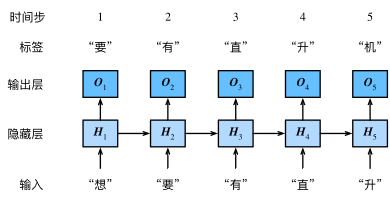

In [2]:
import torch
import torch.nn as nn
import time
import math
import sys
sys.path.append("/home/kesci/input")
import d2l_jay9460 as d2l
(corpus_indices, char_to_idx, idx_to_char, vocab_size) = d2l.load_data_jay_lyrics()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#实现one-hot
def one_hot(x, n_class, dtype=torch.float32):
    result = torch.zeros(x.shape[0], n_class, dtype=dtype, device=x.device)  # shape: (n, n_class)
    result.scatter_(1, x.long().view(-1, 1), 1)  # result[i, x[i, 0]] = 1
    return result

def to_onehot(X, n_class):
    return [one_hot(X[:, i], n_class) for i in range(X.shape[1])]
    
#初始化模型参数
num_inputs, num_hiddens, num_outputs = vocab_size, 256, vocab_size

def get_params():
    def _one(shape):
        param = torch.zeros(shape, device=device, dtype=torch.float32)
        nn.init.normal_(param, 0, 0.01)
        return torch.nn.Parameter(param)

    # 隐藏层参数
    W_xh = _one((num_inputs, num_hiddens))
    W_hh = _one((num_hiddens, num_hiddens))
    b_h = torch.nn.Parameter(torch.zeros(num_hiddens, device=device))
    # 输出层参数
    W_hq = _one((num_hiddens, num_outputs))
    b_q = torch.nn.Parameter(torch.zeros(num_outputs, device=device))
    return (W_xh, W_hh, b_h, W_hq, b_q)
    
#定义模型
def rnn(inputs, state, params):
    # inputs和outputs皆为num_steps个形状为(batch_size, vocab_size)的矩阵
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        H = torch.tanh(torch.matmul(X, W_xh) + torch.matmul(H, W_hh) + b_h)
        Y = torch.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return outputs, (H,)
    
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

#裁剪梯度   
def grad_clipping(params, theta, device):
    norm = torch.tensor([0.0], device=device)
    for param in params:
        norm += (param.grad.data ** 2).sum()
    norm = norm.sqrt().item()
    if norm > theta:
        for param in params:
            param.grad.data *= (theta / norm)
            
#定义预测函数
def predict_rnn(prefix, num_chars, rnn, params, init_rnn_state,
                num_hiddens, vocab_size, device, idx_to_char, char_to_idx):
    state = init_rnn_state(1, num_hiddens, device)
    output = [char_to_idx[prefix[0]]]   # output记录prefix加上预测的num_chars个字符
    for t in range(num_chars + len(prefix) - 1):
        # 将上一时间步的输出作为当前时间步的输入
        X = to_onehot(torch.tensor([[output[-1]]], device=device), vocab_size)
        # 计算输出和更新隐藏状态
        (Y, state) = rnn(X, state, params)
        # 下一个时间步的输入是prefix里的字符或者当前的最佳预测字符
        if t < len(prefix) - 1:
            output.append(char_to_idx[prefix[t + 1]])
        else:
            output.append(Y[0].argmax(dim=1).item())
    return ''.join([idx_to_char[i] for i in output])

def train_and_predict_rnn(rnn, get_params, init_rnn_state, num_hiddens,
                          vocab_size, device, corpus_indices, idx_to_char,
                          char_to_idx, is_random_iter, num_epochs, num_steps,
                          lr, clipping_theta, batch_size, pred_period,
                          pred_len, prefixes):
    if is_random_iter:
        data_iter_fn = d2l.data_iter_random
    else:
        data_iter_fn = d2l.data_iter_consecutive
    params = get_params()
    loss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        if not is_random_iter:  # 如使用相邻采样，在epoch开始时初始化隐藏状态
            state = init_rnn_state(batch_size, num_hiddens, device)
        l_sum, n, start = 0.0, 0, time.time()
        data_iter = data_iter_fn(corpus_indices, batch_size, num_steps, device)
        for X, Y in data_iter:
            if is_random_iter:  # 如使用随机采样，在每个小批量更新前初始化隐藏状态
                state = init_rnn_state(batch_size, num_hiddens, device)
            else:  # 否则需要使用detach函数从计算图分离隐藏状态
                for s in state:
                    s.detach_()
            # inputs是num_steps个形状为(batch_size, vocab_size)的矩阵
            inputs = to_onehot(X, vocab_size)
            # outputs有num_steps个形状为(batch_size, vocab_size)的矩阵
            (outputs, state) = rnn(inputs, state, params)
            # 拼接之后形状为(num_steps * batch_size, vocab_size)
            outputs = torch.cat(outputs, dim=0)
            # Y的形状是(batch_size, num_steps)，转置后再变成形状为
            # (num_steps * batch_size,)的向量，这样跟输出的行一一对应
            y = torch.flatten(Y.T)
            # 使用交叉熵损失计算平均分类误差
            l = loss(outputs, y.long())
            
            # 梯度清0
            if params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            grad_clipping(params, clipping_theta, device)  # 裁剪梯度
            d2l.sgd(params, lr, 1)  # 因为误差已经取过均值，梯度不用再做平均
            l_sum += l.item() * y.shape[0]
            n += y.shape[0]

        if (epoch + 1) % pred_period == 0:
            print('epoch %d, perplexity %f, time %.2f sec' % (
                epoch + 1, math.exp(l_sum / n), time.time() - start))
            for prefix in prefixes:
                print(' -', predict_rnn(prefix, pred_len, rnn, params, init_rnn_state,
                    num_hiddens, vocab_size, device, idx_to_char, char_to_idx))
                    
num_epochs, num_steps, batch_size, lr, clipping_theta = 250, 35, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 50, 50, ['分开', '不分开']                    

#采用随机采样训练模型并创作歌词
train_and_predict_rnn(rnn, get_params, init_rnn_state, num_hiddens,
                      vocab_size, device, corpus_indices, idx_to_char,
                      char_to_idx, True, num_epochs, num_steps, lr,
                      clipping_theta, batch_size, pred_period, pred_len,
                      prefixes)       
#采用相邻采样训练模型并创作歌词                      
train_and_predict_rnn(rnn, get_params, init_rnn_state, num_hiddens,
                      vocab_size, device, corpus_indices, idx_to_char,
                      char_to_idx, False, num_epochs, num_steps, lr,
                      clipping_theta, batch_size, pred_period, pred_len,
                      prefixes)                      

epoch 50, perplexity 66.905005, time 0.66 sec
 - 分开 我不要这生 我不 我想你的爱你 我不要你想你 我不要这 你使我 别怪我 我不就 一九两颗三颗四步 
 - 不分开 快颗我 别你我 三颗我 别你的颗我 我不能再想你 我知 这你再 你什么 一颗四颗三颗四步望步四颗我
epoch 100, perplexity 9.921061, time 0.61 sec
 - 分开 一颗两剧 在一定空 在一定空 你在不空 你一定空 你在不空 你不了空 不么不空 你不定空 你我不定
 - 不分开吗 我不要再想 我不 我不 我不 我不 我不 我不 我不 我不 我不 我不 我不 我不 我不 我不 
epoch 150, perplexity 2.876940, time 0.61 sec
 - 分开 有蟑去用教 有话就没有喝水也能活 脑袋瓜有一点秀逗 猎物死了它比谁都难过 印地安的字迹依然清晰 深
 - 不分开扫 我不能再想 我不 再不 我不能再想 我不 我不 我不要再想你 不知不觉 你已经离开我 不知不觉 
epoch 200, perplexity 1.611338, time 0.61 sec
 - 分开 不愿去对三 用只拽  全要怕空屋前的河牵就 无地的老斑鸠  一成了里 我跟悔努力  没有你在我有多
 - 不分开期 我后能 你你我的太头就怎么卷下 看能开化来香下不及 说我一定熟力 周杰会不多 除非温没 全家怕日
epoch 250, perplexity 1.307554, time 0.61 sec
 - 分开 沙什么不霜落 哼哼哈兮 是谁用 太诉我的见画一只 家地就红开永 快使用双截棍 哼哼哈兮 快使用双截
 - 不分开扫 我叫你爸说你的家桌就像 我可你 开子我 我有大声宣布 你怀手 安里的你像语言暴力 我已无能为力再


In [4]:
rnn_layer = nn.RNN(input_size=vocab_size, hidden_size=num_hiddens)
num_steps, batch_size = 35, 2
X = torch.rand(num_steps, batch_size, vocab_size)
state = None
Y, state_new = rnn_layer(X, state)

#定义模型
class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size):
        super(RNNModel, self).__init__()
        self.rnn = rnn_layer
        self.hidden_size = rnn_layer.hidden_size * (2 if rnn_layer.bidirectional else 1) 
        self.vocab_size = vocab_size
        self.dense = nn.Linear(self.hidden_size, vocab_size)

    def forward(self, inputs, state):
        # inputs.shape: (batch_size, num_steps)
        X = to_onehot(inputs, vocab_size)
        X = torch.stack(X)  # X.shape: (num_steps, batch_size, vocab_size)
        hiddens, state = self.rnn(X, state)
        hiddens = hiddens.view(-1, hiddens.shape[-1])  # hiddens.shape: (num_steps * batch_size, hidden_size)
        output = self.dense(hiddens)
        return output, state
        
#实现一个预测函数，与前面的区别在于前向计算和初始化隐藏状态
def predict_rnn_pytorch(prefix, num_chars, model, vocab_size, device, idx_to_char,
                      char_to_idx):
    state = None
    output = [char_to_idx[prefix[0]]]  # output记录prefix加上预测的num_chars个字符
    for t in range(num_chars + len(prefix) - 1):
        X = torch.tensor([output[-1]], device=device).view(1, 1)
        (Y, state) = model(X, state)  # 前向计算不需要传入模型参数
        if t < len(prefix) - 1:
            output.append(char_to_idx[prefix[t + 1]])
        else:
            output.append(Y.argmax(dim=1).item())
    return ''.join([idx_to_char[i] for i in output])

model = RNNModel(rnn_layer, vocab_size).to(device)
    
#相邻采样
def train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                                corpus_indices, idx_to_char, char_to_idx,
                                num_epochs, num_steps, lr, clipping_theta,
                                batch_size, pred_period, pred_len, prefixes):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    for epoch in range(num_epochs):
        l_sum, n, start = 0.0, 0, time.time()
        data_iter = d2l.data_iter_consecutive(corpus_indices, batch_size, num_steps, device) # 相邻采样
        state = None
        for X, Y in data_iter:
            if state is not None:
                # 使用detach函数从计算图分离隐藏状态
                if isinstance (state, tuple): # LSTM, state:(h, c)  
                    state[0].detach_()
                    state[1].detach_()
                else: 
                    state.detach_()
            (output, state) = model(X, state) # output.shape: (num_steps * batch_size, vocab_size)
            y = torch.flatten(Y.T)
            l = loss(output, y.long())
            
            optimizer.zero_grad()
            l.backward()
            grad_clipping(model.parameters(), clipping_theta, device)
            optimizer.step()
            l_sum += l.item() * y.shape[0]
            n += y.shape[0]
        

        if (epoch + 1) % pred_period == 0:
            print('epoch %d, perplexity %f, time %.2f sec' % (
                epoch + 1, math.exp(l_sum / n), time.time() - start))
            for prefix in prefixes:
                print(' -', predict_rnn_pytorch(
                    prefix, pred_len, model, vocab_size, device, idx_to_char,
                    char_to_idx))

num_epochs, batch_size, lr, clipping_theta = 250, 32, 1e-3, 1e-2
pred_period, pred_len, prefixes = 50, 50, ['分开', '不分开']
train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                            corpus_indices, idx_to_char, char_to_idx,
                            num_epochs, num_steps, lr, clipping_theta,
                            batch_size, pred_period, pred_len, prefixes)

epoch 50, perplexity 10.271949, time 0.41 sec
 - 分开 我想你你在我面多 一枝杨柳 你在一场  满天的让我面红的可爱女人 坏坏的让我疯狂的可爱女人 坏坏的
 - 不分开 我想你你不你 我 你这样牵着你的手爱女人 坏坏的让我疯狂的可爱女人 坏坏的让我疯狂的可爱女人 坏坏
epoch 100, perplexity 1.295111, time 0.42 sec
 - 分开 我不了口让 在不知篮觉 你已经很久  不知不觉 我跟了这节奏 后知后觉 又过了一个秋 后知后觉 我
 - 不分开 你说啊爸你怎么打我妈妈这样不了口简 我  有念再考倒我 说散 你想很久了吧? 败给你的黑色幽默 说
epoch 150, perplexity 1.068281, time 0.47 sec
 - 分开 我不起跳你的我  这样的那年 我爱你的让美演出的可不戏 宁愿心碎哭泣 再狠狠忘记 你爱过我的证据 
 - 不分开 你说啊爸你怎么打我手 一说走 如果我的见你是一场悲剧 我可以让我满腔的怒火 我想揍你已经很久 别想
epoch 200, perplexity 1.032214, time 0.42 sec
 - 分开 我不起跳广句语 我都娘子我爱你的模 语沉默 一壶好酒 再来一碗热粥 配上几斤的牛肉 我说店小二 三
 - 不分开 你说啊话你怎么打我手 你说啊 是不是你不想活 说你怎么面对我 甩开球我满腔的怒火 我想揍你已经很久
epoch 250, perplexity 1.019992, time 0.42 sec
 - 分开 我不够翻译  我这样 那活  爱你 手过一阵莫名感动 我想带你 回我开外婆家 一起看着日落 一直到
 - 不分开 你喝水也能活 脑袋瓜有一点秀逗 猎物死了它比谁都难过 印地安斑鸠 会学人开口 仙人掌怕羞 蜥蝪横著
